In [18]:
from typing import List, Tuple
from enum import Enum
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as st
import seaborn as sns

class FrequencyType(Enum):
    ABSOLUTE = 'absolute'
    RELATIVE = 'relative'
    ABSOLUTE_CUMULATIVE = 'absolute_cumulative'
    RELATIVE_CUMULATIVE = 'relative_cumulative'
    ABSOLUTE_CUMULATIVE_LT = 'absolute_ut'
    RELATIVE_CUMULATIVE_LT = 'relative_lt'

class FrequencyAnalysis:
    def __init__(
        self, data: List[float | int],
        num_classes: int = 0,
        class_width: float = 0.0
    ):
        self.data = np.array(data)
        self.data_len = len(self.data)
        self.min = self.data.min()
        self.max = self.data.max()
        self.mean = np.mean(self.data)
        self.range = self.max - self.min
        self.num_classes = num_classes if num_classes else self._sturges_rule()
        self.class_width = class_width if class_width else self._calculate_class_width()
        self.intervals = self._create_intervals()
        self.absolute_freq = self._calculate_frequencies()
        self.relative_freq = self.absolute_freq / self.data_len
        self.cumulative_freq = np.cumsum(self.absolute_freq)
        self.cumulative_relative_freq = np.cumsum(self.relative_freq)
        self.bins = np.arange(self.min, self.max + self.class_width, self.class_width)
        self.bins_center = (self.bins[:-1] + self.bins[1:]) / 2
        self.dict_type_frecuencies = {
            FrequencyType.ABSOLUTE: (
                self.absolute_freq,
                'absoluta'
            ),
            FrequencyType.RELATIVE: (
                self.relative_freq,
                'relativa'
            ),
            FrequencyType.ABSOLUTE_CUMULATIVE: (
                self.cumulative_freq,
                'absoluta acumulada'
            ),
            FrequencyType.RELATIVE_CUMULATIVE: (
                self.cumulative_relative_freq,
                'relativa acumulada'
            ),
            FrequencyType.ABSOLUTE_CUMULATIVE_LT: (
                list(reversed(self.cumulative_freq)),
                'absoluta acumulada (menor que)'
            ),
            FrequencyType.RELATIVE_CUMULATIVE_LT: (
                list(reversed(self.cumulative_relative_freq)),
                'relativa acumulada (menor que)'
            )
        }

    def _sturges_rule(self) -> int:
        return int(np.ceil(1 + 3.322 * np.log10(self.data_len)))

    def _calculate_class_width(self) ->  float|int:
        return np.ceil(self.range / self.num_classes)

    def _create_intervals(self) -> List[Tuple[float|int, float|int]]:
        return np.array([
            (
              self.min + i * self.class_width,
              self.min + (i + 1) * self.class_width
            )
              for i in range(self.num_classes)
        ])

    def _calculate_frequencies(self) -> np.ndarray:
        return np.array([
            (
                (self.data >= lower) &
                (self.data <= upper if (i + 1) == self.num_classes else self.data < upper)
            ).sum()
            for i, (lower, upper) in enumerate(self.intervals)
        ])

    def create_distribution_table(self) -> pd.DataFrame:
        return pd.DataFrame({
            "Intervalos": [
                f"[ {lower} - {upper}{' )' if i + 1 != len(self.intervals) else ' ]'}"
                for i, (lower, upper) in enumerate(self.intervals)
            ],
            "mi": self.bins_center.round(1),
            "fi": self.absolute_freq.round(1),
            "Fi": self.cumulative_freq.round(1),
            "hi": self.relative_freq.round(3),
            "Hi": self.cumulative_relative_freq.round(3),
            "pi": (self.relative_freq * 100).round(1),
            "Pi": (self.cumulative_relative_freq * 100).round(1)
        }, range(1, len(self.intervals)+1))

    def plot_histogram(self, relative=False, polygon=False):
      # Crear una nueva figura y ejes
      fig, ax = plt.subplots(figsize=(10, 6))

      # Calcular los pesos si es relativo
      weights = np.ones_like(self.data) / self.data_len if relative else None

      # Crear el histograma con estilo minimalista
      ax.hist(
          self.data,
          self.bins,
          weights=weights,
          edgecolor='black',  # Bordes negros
          color='#DDDDDD',  # Color gris claro para las barras
      )

      frecuencias = self.relative_freq if relative else self.absolute_freq

      # Etiquetar cada barra con su frecuencia en estilo minimalista
      for rect, freq in zip(ax.patches, frecuencias):  # Usar ax.patches para obtener las barras
          height = rect.get_height()
          ax.text(
              rect.get_x() + rect.get_width() / 2,
              height + 0.05,  # Agregar un pequeño espacio vertical
              f'{round(freq, 2)}',
              va='bottom',
              ha='center',
              fontsize=10,  # Ajustar el tamaño de la fuente
              color='#333333',  # Color gris oscuro para las etiquetas
          )

      # Agregar polígono de frecuencia si se solicita, en estilo minimalista
      if polygon:
          ax.plot(
              self.bins_center,
              frecuencias,
              'o-',
              label='Polígono de frecuencia',
              color='#333333',  # Color gris oscuro para la línea
              linewidth=1.5,  # Ajustar el grosor de la línea
          )
          ax.legend(fontsize=10)  # Ajustar el tamaño de la fuente de la leyenda

      # Configurar título y etiquetas de ejes en estilo minimalista
      ax.set_title(
          'Histograma',
          fontsize=14,
          fontweight='normal',
          color='#333333',
      )
      ax.set_xlabel('Intervalos', fontsize=12, color='#333333')
      ax.set_ylabel(
          f"Frecuencia {'relativa' if relative else 'absoluta'}",
          fontsize=12,
          color='#333333',
      )

      # Ajustar el diseño y eliminar elementos innecesarios
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.grid(axis='y', linestyle='-', alpha=0.3)
      plt.tight_layout()

      plt.close(fig)
      # Retornar la figura
      return fig

    def plot_ogive(self, type_frecuency: FrequencyType=FrequencyType.ABSOLUTE):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Ogive line with minimalist style
        ax.plot(
            self.bins_center,
            self.dict_type_frecuencies[type_frecuency][0],
            'o-',
            label='Ogiva',
            color='#333333',  # Dark gray line
            linewidth=1.5     # Slightly thicker line for emphasis
        )

        # Frequency labels with minimalist style
        for rect, freq in zip(self.bins_center, self.dict_type_frecuencies[type_frecuency][0]):
            ax.text(
                rect,
                freq,
                f'{round(freq, 2)}',
                va='bottom',
                ha='center',
                fontsize=10,    # Smaller font size
                color='#333333' # Dark gray text color
            )

        # Title and labels with minimalist style
        ax.set_title(
            "Diagrama de ogiva",
            fontsize=14,
            fontweight='normal',
            color='#333333'  # Dark gray title, normal weight
        )
        ax.set_xlabel("Intervalos", fontsize=12, color='#333333')
        ax.set_ylabel(f'Frecuencia {self.dict_type_frecuencies[type_frecuency][1]}', fontsize=12, color='#333333')

        # Minimalist legend
        ax.legend(fontsize=10)

        # Remove spines and add subtle grid
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', linestyle='-', alpha=0.3)  # Subtler grid

        # Adjust layout
        plt.tight_layout()
        plt.close(fig)

        return fig

    def plot_pie_diagram(self):
        fig, ax = plt.subplots(figsize=(12, 6))

        ax.pie(
            self.absolute_freq,
            labels=[f"{lower} - {upper}" for lower, upper in self.intervals],
            autopct='%1.1f%%'
        )

        ax.set_title("Diagrama de torta")

        plt.close()

        return fig

    def calculate_statistics(self) -> dict:
        frequency_counts = Counter(self.data)
        mode = frequency_counts.most_common(1)[0][0]

        return {
            "Media": self.mean,
            "Mediana": np.median(self.data),
            "Moda": mode,
            "Varianza": self.calculate_varianze(),
            "Desviación estandar": self.calculate_varianze()** (1/2),
            "Skewness": pd.Series(self.data).skew(),
            "Kurtosis": pd.Series(self.data).kurtosis()
        }

    def calculate_varianze(self):
        return 1/(self.data_len-1)*(sum(self.data**2)-self.data_len*(self.mean**2))


In [19]:
# Configuración
datos = pd.read_csv('https://raw.githubusercontent.com/pranthony/Latex/refs/heads/main/Estadistica%20y%20probabilidad/MockData/finaldata.csv')
numeric_columns = datos.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    datos[col] = datos[col].fillna(datos[col].median())
datos

,Id,edad,genero,año,dispositivos_disponibles,tipo_conexion,calidad_internet,uso_plataforma_educativa,uso_db_academica,uso_software_analisis,uso_herramientas_colaboracion,uso_sm_educativa,uso_tiempo_tic,comp_busqueda,comp_data,comp_analisis,comp_presentacion,comp_programacion
0,10R,24,Masculino,4°,2,Fibra óptica,4,5,4,4,4,4,320,4,4,4,4,4
1,11R,24,Masculino,4°,1,Fibra óptica,3,3,3,2,4,4,100,3,4,2,3,2
2,12R,21,Masculino,4°,1,4G/5G,1,4,2,1,4,5,80,2,3,1,3,1
3,13R,21,Masculino,4°,2,4G/5G,3,1,3,3,3,1,70,2,3,3,2,3
4,14A,22,Masculino,3°,2,4G/5G,3,2,2,4,4,3,230,3,4,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,68P,20,Femenino,2°,4,Fibra óptica,3,2,3,2,2,3,130,2,4,2,4,2
68,69P,21,Masculino,2°,2,4G/5G,4,3,4,2,3,4,200,4,4,4,4,3
69,70P,22,Femenino,3°,3,4G/5G,2,5,4,1,4,1,200,3,3,3,4,4
70,71P,23,Masculino,2°,2,Fibra óptica,1,3,3,4,2,4,200,3,2,1,2,1


# A. Datos demográficos de la muestra

## 1. Principales estadisticos

In [32]:
media_edad = datos['edad'].mean()
desviacion_estandar_edad = datos['edad'].std()
umbral_edad = 2 * desviacion_estandar_edad
mascara_atipicos_edad = (datos['edad'] - media_edad).abs() > umbral_edad
datos.loc[mascara_atipicos_edad, 'edad'] = media_edad

analisis_edad = FrequencyAnalysis(datos["edad"])
analisis_edad.calculate_statistics()


{'Media': np.float64(20.87454989711934),
 'Mediana': np.float64(21.0),
 'Moda': np.float64(21.0),
 'Varianza': np.float64(2.2435984319889823),
 'Desviación estandar': np.float64(1.4978646240528488),
 'Skewness': np.float64(-0.008619811576945599),
 'Kurtosis': np.float64(-0.24468197796137492)}


## 2. Tabla de distribucion de frecuencia de edad



In [21]:
import plotly.graph_objects as go

analisis_edad.create_distribution_table()


,Intervalos,mi,fi,Fi,hi,Hi,pi,Pi
1,[ 17.0 - 18.0 ),17.5,4,4,0.056,0.056,5.6,5.6
2,[ 18.0 - 19.0 ),18.5,5,9,0.069,0.125,6.9,12.5
3,[ 19.0 - 20.0 ),19.5,9,18,0.125,0.250,12.5,25.0
4,[ 20.0 - 21.0 ),20.5,11,29,0.153,0.403,15.3,40.3
5,[ 21.0 - 22.0 ),21.5,18,47,0.250,0.653,25.0,65.3
6,[ 22.0 - 23.0 ),22.5,16,63,0.222,0.875,22.2,87.5
7,[ 23.0 - 24.0 ),23.5,4,67,0.056,0.931,5.6,93.1
8,[ 24.0 - 25.0 ],24.5,5,72,0.069,1.000,6.9,100.0


## 3. Histograma de frecuencia absuluta

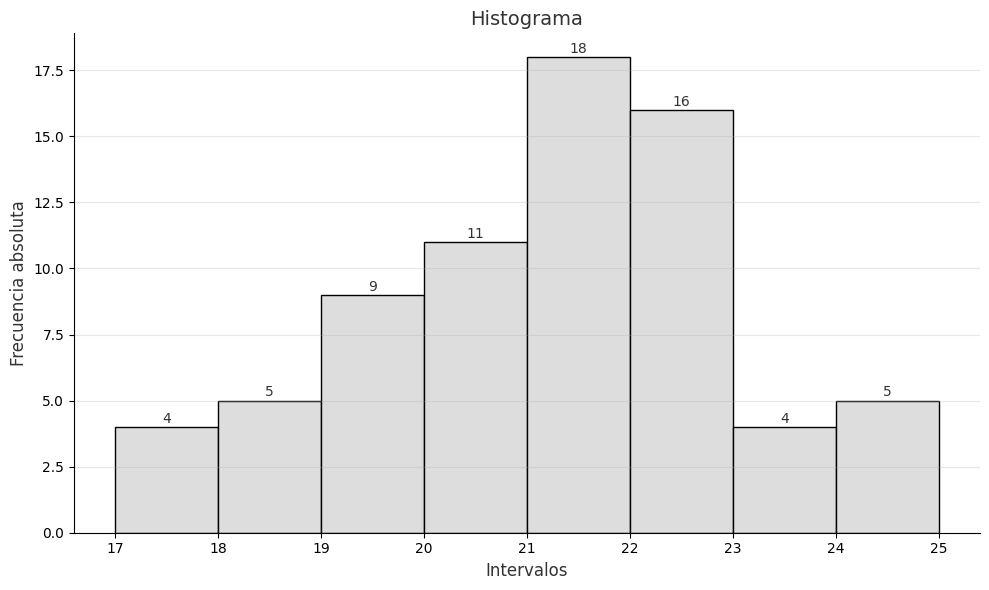

In [22]:
analisis_edad.plot_histogram()

## 4. Grafico de barras comparativo por genero y año

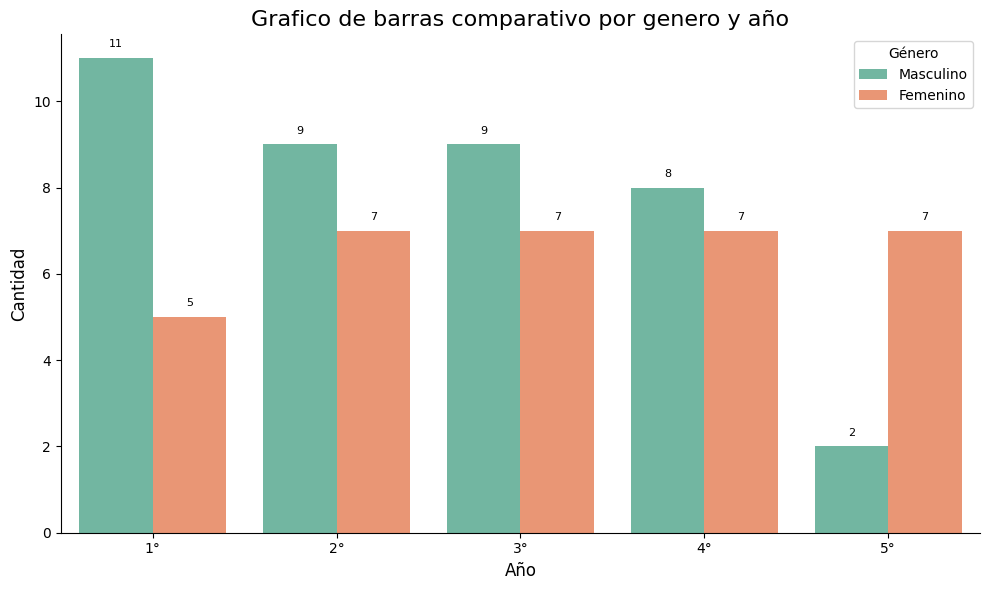

In [23]:

# Crear el gráfico de barras comparativo por género y año
plt.figure(figsize=(10, 6))
sns.countplot(x='año', hue='genero', data=datos, palette='Set2', order=['1°', '2°', '3°', '4°', '5°'])
plt.title('Grafico de barras comparativo por genero y año', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.legend(title='Género', fontsize=10)
ax = plt.gca()
ax.set_facecolor('#fff')
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        label_text = f'{int(height)}'  # Format the label (remove decimals if needed)
        ax.text(bar.get_x() + bar.get_width() / 2,  # X-coordinate of the label
                height + 0.2,                       # Y-coordinate of the label
                label_text,                        # The label text
                ha='center', va='bottom',           # Horizontal and vertical alignment
                fontsize=8, color='black')         # Font size and color
        
plt.gca().spines['top'].set_visible(False)  # Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Ajustar diseño para evitar superposición
plt.show()

# B. Análisis de la brecha digital



## 1. Acceso

### 1.a. Disponibilidad de dispositivos electrónicos

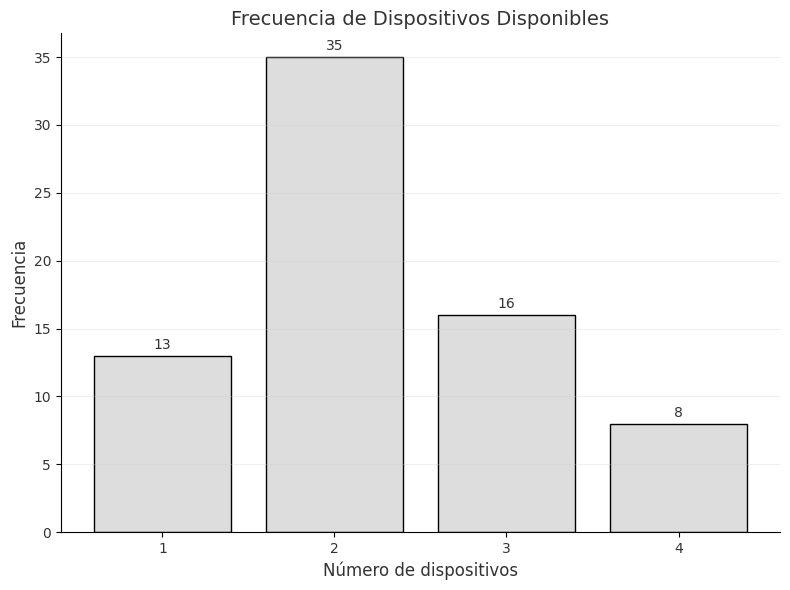

In [24]:
# Datos para la gráfica de barras
frecuencias = datos['dispositivos_disponibles'].value_counts().sort_index()
categorias = frecuencias.index
valores = frecuencias.values

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(categorias, valores, color='#DDDDDD', edgecolor='black', width=0.8)  # Light gray bars

# Añadir etiquetas encima de cada barra
for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, altura + 0.5, f'{int(altura)}',
             ha='center', fontsize=10, color='#333333')  # Dark gray text

# Minimalist style adjustments:
plt.title('Frecuencia de Dispositivos Disponibles', fontsize=14,
          fontweight='normal', color='#333333')  # Dark gray title, normal weight
plt.xlabel('Número de dispositivos', fontsize=12, color='#333333')
plt.ylabel('Frecuencia', fontsize=12, color='#333333')
plt.xticks(categorias, fontsize=10, color='#333333')
plt.yticks(fontsize=10, color='#333333')
plt.grid(axis='y', linestyle='-', alpha=0.3, color='#CCCCCC')  # Subtler grid
plt.gca().spines['top'].set_visible(False)  # Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

### 1.b. Distribucion de tipos de conexión

In [25]:
import plotly.express as px

# Create the pie chart
fig = px.pie(datos, names='tipo_conexion', title='Distribución de Tipos de Conexión', color_discrete_sequence=px.colors.qualitative.Pastel)

# Customize the chart for a minimalist style
fig.update_traces(textinfo='percent+label', textposition='inside')
fig.update_layout(
    title_font_size=20,  # Adjust title font size
 
    paper_bgcolor='rgba(0,0,0,0)', # Set transparent background
    plot_bgcolor='rgba(0,0,0,0)',
)
# Center the title:
fig.update_layout(title_x=0.5)

fig.show()


### 1.c. Valoración de la calidad de internet

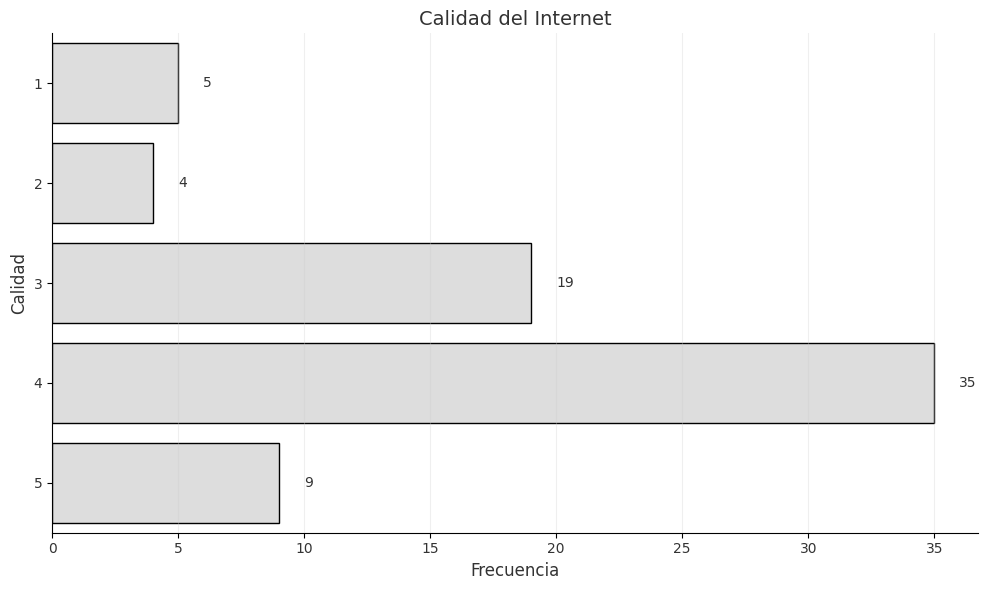

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='calidad_internet', data=datos, color='#DDDDDD', edgecolor='black')

plt.title('Calidad del Internet', fontsize=14, fontweight='normal', color='#333333')
plt.xlabel('Frecuencia', fontsize=12, color='#333333')
plt.ylabel('Calidad', fontsize=12, color='#333333')
plt.xticks(fontsize=10, color='#333333')
plt.yticks(fontsize=10, color='#333333')
plt.grid(axis='x', linestyle='-', alpha=0.3, color='#CCCCCC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add frequency labels:
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1,       # Position the text (x-coordinate)
            p.get_y() + p.get_height() / 2, # Position the text (y-coordinate)
            '{:1.0f}'.format(width), # Format the text (remove decimals)
            ha="left",
            va='center',
            fontsize=10,
            color='#333333')  # Dark gray text color

plt.tight_layout()
plt.show()

## 2. Uso

### 2.a. Grafio de proposito de uso

<Figure size 1000x600 with 0 Axes>

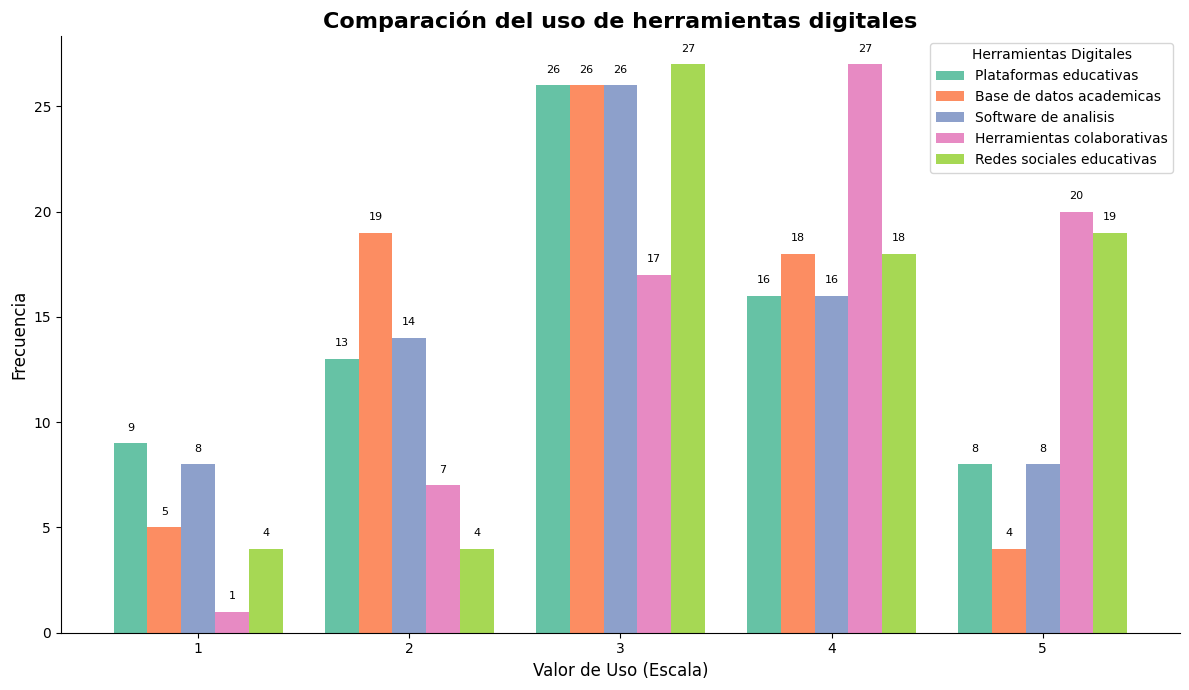

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting relevant columns for the bar chart
columns = [
    "uso_plataforma_educativa",
    "uso_db_academica",
    "uso_software_analisis",
    "uso_herramientas_colaboracion",
    "uso_sm_educativa"
]

# Summarizing the frequency of each value per column
frequencies = datos[columns].apply(pd.Series.value_counts).fillna(0)

# Plotting a multiple bar chart
plt.figure(figsize=(10, 6))
frequencies.plot(kind="bar", width=0.8, figsize=(12, 7), color=sns.color_palette("Set2", len(columns)))

# Customizing the chart
plt.title("Comparación del uso de herramientas digitales", fontsize=16, weight='bold')
plt.xlabel("Valor de Uso (Escala)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="Herramientas Digitales", fontsize=10, labels=['Plataformas educativas', 'Base de datos academicas', 'Software de analisis', 'Herramientas colaborativas', 'Redes sociales educativas'])
sns.despine()
plt.tight_layout()

ax = plt.gca()  # Get the current axes
ax.set_facecolor('#fff')
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        label_text = f'{int(height)}'  # Format the label (remove decimals if needed)
        ax.text(bar.get_x() + bar.get_width() / 2,  # X-coordinate of the label
                height + 0.5,                       # Y-coordinate of the label
                label_text,                        # The label text
                ha='center', va='bottom',           # Horizontal and vertical alignment
                fontsize=8, color='black')         # Font size and color


# Display the plot
plt.show()


### 2.b. Frecuencia de uso (ninutos al dia)

In [28]:
tiempo_uso = datos["uso_tiempo_tic"]
analisis = FrequencyAnalysis(tiempo_uso)

analisis.create_distribution_table()


,Intervalos,mi,fi,Fi,hi,Hi,pi,Pi
1,[ 30.0 - 77.0 ),53.5,13,13,0.181,0.181,18.1,18.1
2,[ 77.0 - 124.0 ),100.5,14,27,0.194,0.375,19.4,37.5
3,[ 124.0 - 171.0 ),147.5,11,38,0.153,0.528,15.3,52.8
4,[ 171.0 - 218.0 ),194.5,14,52,0.194,0.722,19.4,72.2
5,[ 218.0 - 265.0 ),241.5,9,61,0.125,0.847,12.5,84.7
6,[ 265.0 - 312.0 ),288.5,2,63,0.028,0.875,2.8,87.5
7,[ 312.0 - 359.0 ),335.5,3,66,0.042,0.917,4.2,91.7
8,[ 359.0 - 406.0 ],382.5,6,72,0.083,1.000,8.3,100.0


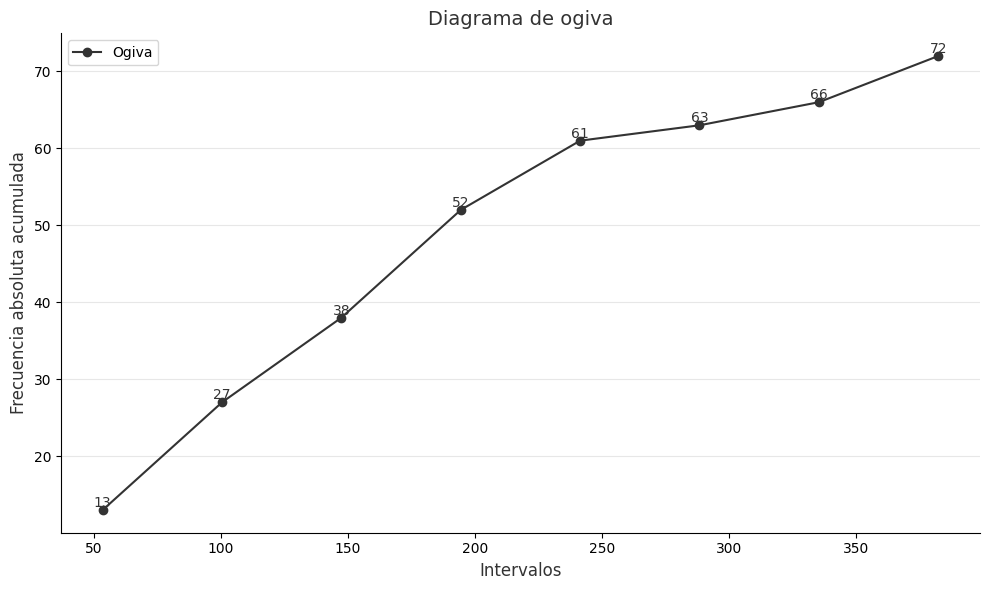

In [29]:
analisis.plot_ogive(FrequencyType.ABSOLUTE_CUMULATIVE)

In [30]:
analisis.calculate_statistics()


{'Media': np.float64(171.80555555555554),
 'Mediana': np.float64(170.0),
 'Moda': np.int64(200),
 'Varianza': np.float64(10245.989827856029),
 'Desviación estandar': np.float64(101.22247689054062),
 'Skewness': np.float64(0.6785566371561325),
 'Kurtosis': np.float64(-0.26084073307968847)}

## 3. Habilidades digitales

### 3.a. Competencias para utilizar las TIC de manera efectiva


<Figure size 1000x600 with 0 Axes>

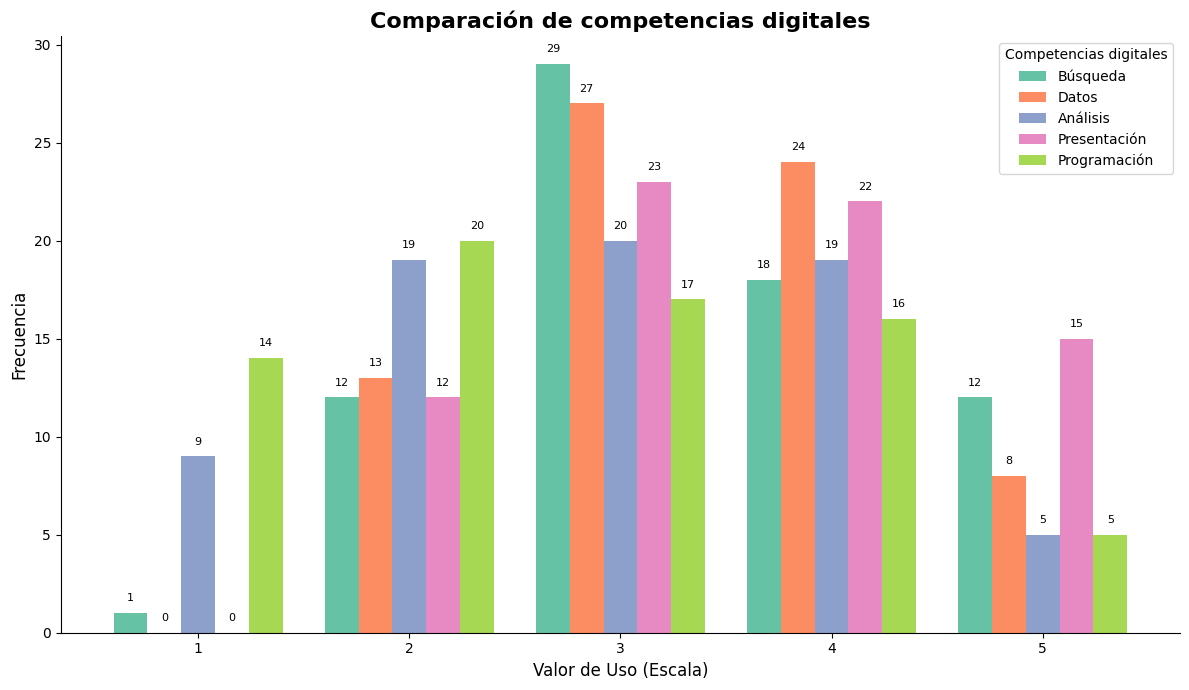

In [31]:

# Extracting relevant columns for the bar chart
columns = [
    "comp_busqueda",
    "comp_data",
    "comp_analisis",
    "comp_presentacion",
    "comp_programacion"
]

# Summarizing the frequency of each value per column
frequencies = datos[columns].apply(pd.Series.value_counts).fillna(0)

# Plotting a multiple bar chart
plt.figure(figsize=(10, 6))
frequencies.plot(kind="bar", width=0.8, figsize=(12, 7), color=sns.color_palette("Set2", len(columns)))

# Customizing the chart
plt.title("Comparación de competencias digitales", fontsize=16, weight='bold')
plt.xlabel("Valor de Uso (Escala)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="Competencias digitales", fontsize=10, labels=['Búsqueda', 'Datos', 'Análisis', 'Presentación', 'Programación'])
sns.despine()
plt.tight_layout()

ax = plt.gca()  # Get the current axes
ax.set_facecolor('#fff')

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        label_text = f'{int(height)}'  # Format the label (remove decimals if needed)
        ax.text(bar.get_x() + bar.get_width() / 2,  # X-coordinate of the label
                height + 0.5,                       # Y-coordinate of the label
                label_text,                        # The label text
                ha='center', va='bottom',           # Horizontal and vertical alignment
                fontsize=8, color='black')         # Font size and color


# Display the plot
plt.show()
